# Task 1

In this first task you will implement a toy version of the Word2Vec algorithm to produce some simple word embeddings using the Pytorch library.

<br>We will need a corpus to train our embeddings on. To keep computation times low and to be able to produce simpler plots later, we will only use the short text below as a toy corpus.

In [1]:
corpus = "Human language is special for several reasons . It is specifically constructed to convey the speaker / writer's " \
       "meaning . It is a complex system , although little children can learn it pretty quickly . Another remarkable " \
       "thing about human language is that it is all about symbols . According to Chris Manning , a machine learning " \
       "professor at Stanford , it is a discrete , symbolic , categorical signaling system . This means we can convey the " \
       "same meaning in different ways ( i.e. , speech , gesture , signs , etc. ) The encoding by the human brain is a " \
       "continuous pattern of activation by which the symbols are transmitted via continuous signals of sound and " \
       "vision . Understanding human language is considered a difficult task due to its complexity . For example , there " \
       "are an infinite number of different ways to arrange words in a sentence . Also , words can have several meanings " \
       "and contextual information is necessary to correctly interpret sentences . Every language is more or less unique " \
       "and ambiguous . Just take a look at the following newspaper headline \" The Pope’s baby steps on gays . \" This " \
       "sentence clearly has two very different interpretations , which is a pretty good example of the challenges in " \
       "NLP . Note that a perfect understanding of language by a computer would result in an AI that can process the " \
       "whole information that is available on the internet , which in turn would probably result in artificial general " \
       "intelligence ."

<br>In order to train our model, we first need to transform this text into usable training data.
1. Extract the vocabulary from this text. Do not worry about collapsing different forms of the same word into a single entry (e.g. treat "language" and "languages" as separate words). You also do not need to worry about punctuation marks. They are already split from the words in the text where necessary, so you can treat them like individual words. This should result in a list with a single entry for each unique word (make sure to not have multiple entries for e.g. "is").
2. Assign an index to each token in the vocabulary, so that each word can be represented as a distinct number. This is necessary because most machine learning algorithms require all input and output variables to be numeric.
3. Transform our corpus into a series of these indeces.
4. One-Hot encode the corpus using the <i>torch.nn.functional.one_hot()</i> function. You can find the documentation for it [here](https://pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html). This encoding is necessary because the integer values assigned in 2. have a natural ordered relationship between each other (i.e. 1 and 2 are closer than let's say 6) and machine learning algorithms may be able to understand and harness this relationship. However, in our case no ordinal relationship exists, as our assignment is arbitrary. The one-hot encoding creates a binary column for each category and therefore does not introduce a relationship between labels.
5. Convert the resulting tensor so that it contains floating point numbers instead of integers (this is just to make it compatible with our model implementation later).

In [2]:
import torch

def extract_vocabulary(text: str) -> list:
    """Takes a string as input and returns a list of unique tokens contained in the string."""
    tokens = text.split()
    vocabulary = list(set(tokens))
    return vocabulary


def create_word_indices(vocabulary: list) -> dict:
    """Takes a vocabulary as input and returns a dictionary with the words in the vocabulary as keys and an index (int) as values."""
    index_dict = {}
    for word in vocabulary:
        index_dict[word] = vocabulary.index(word)
    return index_dict


def transform_to_indices(text: str, index_dict: dict) -> list:
    """Transform the list of tokens in the corpus (non-unique, in the original order), into a list of indeces using the dictionary constructed by the function above"""
    tokens = text.split()
    corpus_indices = [index_dict[token] for token in tokens]
    return corpus_indices

# apply the functions to the toy corpus
# In the end, you should have a variable containing the corpus as a list of indeces
vocabulary = extract_vocabulary(corpus)
index_dict = create_word_indices(vocabulary)
corpus_indices = transform_to_indices(corpus, index_dict)

# One-hot-encode the text
text_one_hot = torch.nn.functional.one_hot(torch.tensor(corpus_indices, dtype=torch.long))
                                           
text_one_hot = torch.tensor(text_one_hot, dtype=torch.float32) # transfroms the Tensor to contain floats

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


<br>Now costruct the actual training data. We are going to implement the skip-gram version of Word2Vec, using a context window of size 5. This means that for each word, the model should try to predict the two words that come before and after it individually. Thus, the training data should consist of four input-label pairs for each word, for which the four labels are the words in the context window. E.g. for the word "special" in the first sentence of our toy corpus, the pairs would be (special, language), (special, is), (special, for), (special, several). Keep in mind, however, that for our model implementation, we will need two tensors, and not a list of tuples. So you should construct an input tensor containing the one-hot encoded tokens from our toy-corpus four times, and for each of these four entries the label tensor should contain a different word in its context window. Since we are going to use CrossEntropyLoss as our loss function later, the labels should not be one-hot encoded, but simply state the index of the target token (this is simply a characteristic of the torch implementation of cross entropy loss). Cross Entropy loss looks at the output of our model (a list of predicted probabilities for each word to be in the context window of the input word) at the index specified by the label, and assigns a higher loss to the prediction the further the predicted probability is away from 1.<br> You might have noticed that this way of constructing training data is problematic for the first two and the last two tokens in the corpus, because their context window would be out of bounds. Usually, this would be solved by padding (adding two special tokens at the beginning and at the end of the text), but for simplicity's sake, you can just ignore the first and last two tokens in the input tensor.

In [3]:
input_tensor = []
labels = []

for i, entry in enumerate(text_one_hot):
    if i not in [0, 1, len(text_one_hot)-2, len(text_one_hot)-1]:
        input_tensor.extend([entry] * 4)
        labels.extend([corpus_indices[i-2], corpus_indices[i-1], corpus_indices[i+1], corpus_indices[i+2]])

input_tensor = torch.stack(input_tensor, dim=0)

The next step is to construct our model. For easier visualisation later, we want to produce a model with embedding size 2. In reality, Word2Vec models use a much bigger embedding size, usually around 300.<br>
Pytorch uses classes to define models. You can find a code skeleton for such a class below. Define a model in such a way, that it has three layers, an input, a hidden and an output layer. Also apply the Softmax activation function to the output.<br>
We use two fully connected linear networks to connect the input layer to the hidden layer, and the latter to the output layer. The input and output size should be identical and be equal to the size of our vocabulary.

In [4]:
class Word2Vec(torch.nn.Module):

    def __init__(self, input_size):
        super().__init__()
        self.hidden = torch.nn.Linear(input_size, 2) # Linear network connecting input to hidden layer, fill in layer sizes
        self.prediction = torch.nn.Linear(2, input_size) # Linear network connecting embedding to output layer
        self.activation = torch.nn.Softmax(dim=0)
    def forward(self, x):
        x = self.hidden(x)
        x = self.prediction(x)
        x = self.activation(x)
        return x

Now you should instantiate our model. Additionally, define a learning rate (how much the weights of our model should change after each training iteration, usually around 0.01) and how many epochs (how many iterations over the training data) you want to do. More epochs can increase model performance, but also increases computation time, and, because our training data is so small, the model should converge rather quickly, so do not choose an overly high number of epochs. A good point to start might be to choose 100 epochs and then adjust that number, depending on how long your code takes to run. As stated above, we are going to use cross entropy loss as our loss function and Adam as our optimizer (already implemented in the code below). An optimizer handles the way in which the weights of our model should be updated. 

In [5]:
model = Word2Vec(len(text_one_hot[0]))
lr = 0.01
epochs = 1000
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

It is time to train our model now.
1. For each epoch, loop through all training instances.
2. We update our weights after each instance. So you should call your model on each sample, to get a prediction (model(sample)).
3. Compute the loss of each prediction each prediction, by using our defined loss function (Cross Entropy Loss). Pass the prediction and the vocabulary index of the correct word to the loss function.
4. Then, use the <i>.backward()</i> on your loss, and use <i>optimizer.step()</i> and <i>optimizer.zero_grad()</i>. This updates the weights through backpropagation and resets the optimizer gradients.

In [6]:
for epoch in range(epochs):
    for i, sample in enumerate(input_tensor):
        prediction = model(sample)
        l = loss_function(prediction, torch.tensor(labels[i]))
        l.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f'Done with epoch {epoch+1}')

Done with epoch 1
Done with epoch 2
Done with epoch 3
Done with epoch 4
Done with epoch 5
Done with epoch 6
Done with epoch 7
Done with epoch 8
Done with epoch 9
Done with epoch 10
Done with epoch 11
Done with epoch 12
Done with epoch 13
Done with epoch 14
Done with epoch 15
Done with epoch 16
Done with epoch 17
Done with epoch 18
Done with epoch 19
Done with epoch 20
Done with epoch 21
Done with epoch 22
Done with epoch 23
Done with epoch 24
Done with epoch 25
Done with epoch 26
Done with epoch 27
Done with epoch 28
Done with epoch 29
Done with epoch 30
Done with epoch 31
Done with epoch 32
Done with epoch 33
Done with epoch 34
Done with epoch 35
Done with epoch 36
Done with epoch 37
Done with epoch 38
Done with epoch 39
Done with epoch 40
Done with epoch 41
Done with epoch 42
Done with epoch 43
Done with epoch 44
Done with epoch 45
Done with epoch 46
Done with epoch 47
Done with epoch 48
Done with epoch 49
Done with epoch 50
Done with epoch 51
Done with epoch 52
Done with epoch 53
Do

Modify the following code to visualise your embeddings. You simply need to save the hidden layer weights into the <i>weights</i> variable. In the original implementation of Word2Vec, the prediction weights were used as embeddings and not the hidden weights (Mikolov et al., 2013, [Link](https://arxiv.org/abs/1301.3781)). However, in practice, both versions are used.

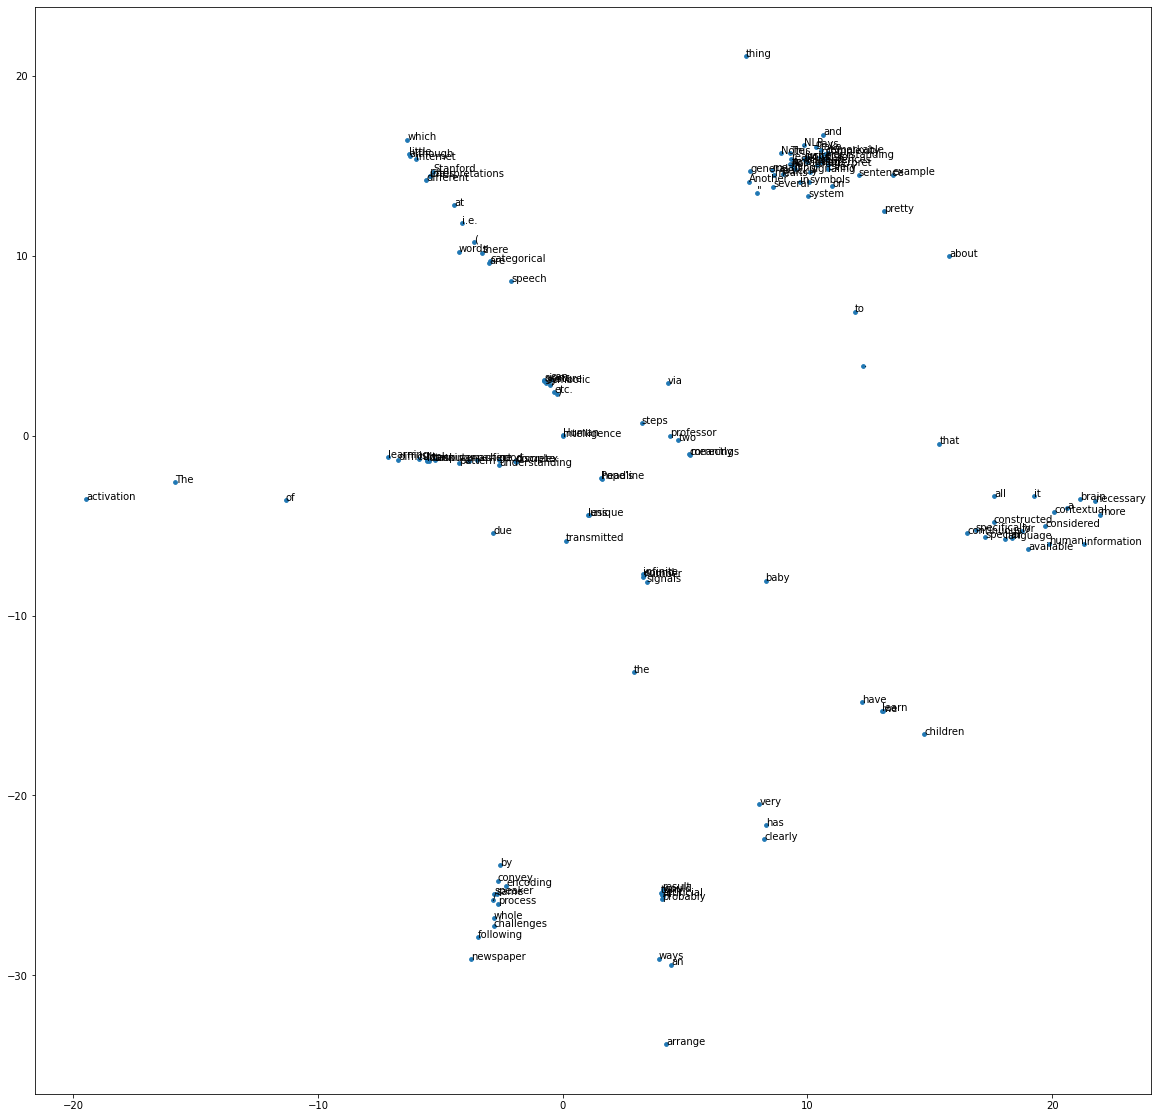

In [7]:
import matplotlib.pyplot as plt
weights = model.hidden.weight
weights.detach_()
weights_dim_1 = weights[0]
weights_dim_2 = weights[1]

plt.rcParams['figure.figsize'] = (20, 20)
plt.scatter(weights_dim_1, weights_dim_2, s=14)
for i, word in enumerate(vocabulary):
    plt.annotate(word, (weights_dim_1[i], weights_dim_2[i]), size= 10)
plt.show()

Obviously, our training data is way too small and our model too simple to produce good embeddings for all tokens in the corpus.<br>
Can you still find some tokens that our model produced meaningful embeddings for? (Hint: look for clusters of tokens you would expect to be close to each other in a vector space representation.)

Example: 'information' and 'language' are rather close together. The results here can vary depending on your implementation/parameters.

# Task 2

In this task, you will finetune a version of BERT (Bidirectional Encoder Representations from Transformers), a transformer based language model, to classify movie reviews on Rotten Tomatoes into positive or negative reviews. The goal is to train the model to predict whether a review is positive (1) or negative (0).
First install the following packages, if you have not done so already:

In [8]:
import sys
!{sys.executable} -m pip install datasets
!{sys.executable} -m pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 432 kB 9.8 MB/s 
     |████████████████████████████████| 115 kB 54.8 MB/s 
     |████████████████████████████████| 163 kB 28.0 MB/s 
     |████████████████████████████████| 212 kB 58.3 MB/s 
     |████████████████████████████████| 127 kB 54.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 8.2 MB/s 
     |████████████████████████████████| 6.6 MB 50.0 MB/s 


<br>Download the dataset using the following command:

In [9]:
from datasets import load_dataset
dataset = load_dataset('rotten_tomatoes')

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Dataset rotten_tomatoes downloaded and prepared to /root/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Look at some entries in the dataset, to familiarize yourself with its contents and structure. You can also have a look at [this website](https://huggingface.co/datasets/rotten_tomatoes) to get some additional information. 

In [10]:
### Your code for data exploration ###

# You do not necessarily need to do anything here, this is just to provide some space to look at the dataset's properties and contents.

# Example
print(dataset['train'][0])

{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .', 'label': 1}


To be able to use the texts in the database, we need them in tokenized form. For this you need to download a tokenizer. The following code snippet downloads a pretrained tokenizer, and tokenizes the dataset:

In [11]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")


def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)


tokenized_datasets = dataset.map(tokenize_function, batched=True)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Using the whole data set would probably make the training process very long, therefore you should only use a small subset of the training and test instances contained in the data set. You can start with around 100 samples, and maybe increase that number if necessary. (Hint: use the .shuffle and .select method of the Dataset class. The documentation can be found [here](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset).)

In [12]:
### Complete the following code ###

small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(100))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(100))

Load the distilbert model (a smaller version of the full BERT model) and the evaluation metric to be used (in this case 'accuracy'). Fill in the number of labels the classification model should use. (Do not worry about the warning, it does not concern the task at hand.) The model will take a series of input tokens, which is why we had to tokenise the reviews, and returns a logit for each possible label, which indicates how likely it is that the input sequence corresponds to that label, according to the model's prediction. The evaluation metric is used to calculate how likely the predictions that the model makes are correct.

In [13]:
from transformers import AutoModelForSequenceClassification
from datasets import load_metric
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)

metric = load_metric("accuracy")

Downloading:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.weigh

In order to compute the metric for the predictions our model makes, we will need to first convert the logits that the model returns into the corresponding class label. The following function will do this:

In [18]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), axis=-1)
    return metric.compute(predictions=predictions, references=labels)

Before training, specify the training arguments. The most important ones here are the number of epochs to be used and the evaluation strategy: Use 'epoch' as an argument to evaluate your model after each epoch or 'step' to evaluate it after each weight update step. As for the number of epochs, since this model does many more computations per epoch compared to the one you implemented in task 1, you should choose a much lower value. A good starting point is to set the num_training_epochs parameter to 3, and then adjust as needed. If you are interested and would like to tweak other arguments, you can find a list of them [here](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments).

In [19]:
from transformers import TrainingArguments
training_args = TrainingArguments(output_dir='my_training_dir', evaluation_strategy="epoch", num_train_epochs=3)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


The transformers library comes with a Trainer class, that streamlines the training process. Create an instance of this class and pass your base model, your training arguments, your training data set, your evaluation data set and the compute_metrics function to it. 

In [20]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

Start the training by calling .train() on your trainer.

In [21]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 100
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.613902,0.660000
2,No log,0.568553,0.750000
3,No log,0.667948,0.740000


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 100
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 100
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 100


TrainOutput(global_step=39, training_loss=0.2387562776223207, metrics={'train_runtime': 1063.2592, 'train_samples_per_second': 0.282, 'train_steps_per_second': 0.037, 'total_flos': 39740219596800.0, 'train_loss': 0.2387562776223207, 'epoch': 3.0})

What accuracy did your model achieve at the end of the training process?

Answer: 0.71

Now you should do some predictions using your model. Use the TextClassificationPipeline class included in the transformers library to write a function which takes any string as an input and returns 'POSITIVE' if your model thinks the input was a positive review, and 'NEGATIVE' otherwise. Hint: look at the output of the pipeline first.

In [22]:
from transformers import TextClassificationPipeline

pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)

print(pipeline('This movie was awesome from start to finish')) 

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/text_classification.py:90: UserWarning: `return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality
  "`return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality", UserWarning


[[{'label': 'LABEL_0', 'score': 0.12075191736221313}, {'label': 'LABEL_1', 'score': 0.8792480826377869}]]


In [23]:
def predict(review:str) -> str:
    prediction = pipeline(review)
    print(prediction)
    if prediction[0][0]['score'] > prediction[0][1]['score']:
        return 'NEGATIVE'
    else:
        return 'POSITIVE'

print(predict('This movie was awesome from start to finish'))

[[{'label': 'LABEL_0', 'score': 0.12075191736221313}, {'label': 'LABEL_1', 'score': 0.8792480826377869}]]
POSITIVE


Could you find any kind of prompts your model struggles to classify correctly?

Reviews containing words that are often negatively connotated, but can be used positively depending on context such as 'This movie was sick!' are often wrongly categorised as 'negative'.